In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


import numpy as np
import numpy.random as npr # for alias method


import os

%matplotlib inline

In [2]:
def alias_setup(probs):
    K       = len(probs)
    q       = np.zeros(K)
    J       = np.zeros(K, dtype=np.int)
 
    # Sort the data into the outcomes with probabilities
    # that are larger and smaller than 1/K.
    smaller = []
    larger  = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)
 
    # Loop though and create little binary mixtures that
    # appropriately allocate the larger outcomes over the
    # overall uniform mixture.
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()
 
        J[small] = large
        q[large] = q[large] - (1.0 - q[small])
 
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)
 
    return J, q
np.random.seed(0)
def alias_draw(J, q):
    K  = len(J)
 
    # Draw from the overall uniform mixture.
    kk = int(np.floor(npr.rand()*K))
 
    # Draw from the binary mixture, either keeping the
    # small one, or choosing the associated larger one.
    if npr.rand() < q[kk]:
        return kk
    else:
        return J[kk]


def my_alias(p):
    """
    Takes in a discrete probability vector and returns the index to be choosen based on the distribution.
    """
    J, q = alias_setup(p)
    n = p.shape[0]
#     X = np.zeros(N)
    x = alias_draw(J, q)
    v = np.zeros(n)
    v[x] = 1
    return v

In [3]:
def unroll(W):
    """
    Unrolls a (n, n) array into a (n * n, 1) array
    """
    n = W.shape[0]
    return W.reshape(n * n, 1)

def ununroll(W):
    """
    Ununroll a (n * n, 1) array into a (n, n) array
    """
    m = W.shape[0]
    n = int(np.sqrt(m))
    return W.reshape(n, n)

In [4]:
def cal_reward(alpha, p):
    """
    Calculates reward at time t. Returns a (n, 1) numpy array with the expected rewards generated by each project. 
    Plus one at the end to prevent zero reward.
    This output can be thought of as the expected reward obtained if the agents choose the projects based
    on their probability distributions.
    Inputs:
    - alpha:  (n, n) numpy array of aptitudes; alpha(i,j) denoting the aptitude of agent i on project j.
    - p: (n, n) numpy array where each row denotes distribution of each agent working on the projects.
    """
    n = p.shape[0]
    s = np.zeros((n,n))
    for i in np.arange(n):
        s[i, :] = my_alias(p[i, :])
    return s, np.log(np.sum(s * alpha, axis = 0) + 1)


In [5]:
# def initializepara(n):
#     a = np.ones((n,1))
#     r = np.ones((n,1))
#     alpha = a.dot(r.T)
#     R = np.zeros((n,1))
#     W = np.ones((n,n))
#     p = W / np.sum(W, axis = 1).reshape(n,1)
#     return a, r, alpha, R, W, p


def cal_utility(x, R):
    """
    Computes the utiliy for each agent at each time step. Returns a (n, n) numpy array with the i,j being
    the utility of agent i from project j.
    Inputs:
    - x: (n, n) numpy array representing the decision variable to optimize incentives. The columns sum to 1. 
    - R: (n, 1) numpy array with the expected rewards generated by each project.
    """
    R = R.reshape(n,1)
    return x * R 

def xupdates(s):
    v = s / np.sum(s, axis = 0) 
    d = np.isnan(v)
    v[d] = 0
    return v


def weightupdates(epsilon, W, u):
    """
    Takes in the weight W at time t and performs one timestep. Returns the weights at time t+1.
    Input:
    - epsilon: a real valued number in [0, 0.5] that does the weight updates.
    - W: a (n, n) array of weights with i,j being the weight for project j for agent i. 
    - u: a (n, n) array that the weight updates are based on.
    """
    return W * np.power((1 + epsilon), u)

def normalizew(W):
    """
    Takes in the weights and normalizes them.
    Input:
    - W: (n, n) numpy array of weights.
    """
    return W / np.sum(W, axis = 1).reshape(n,1)

def one_step(W, alpha, epsilon):
    """
    Takes in weights, reward, x, alpha and epsilon at time t and produces the new weights for time t+1.
    We shall take alpha and epsilon to be constant for the time being.
    """
    p = normalizew(W) # normalize weights at time t
    s, R = cal_reward(alpha, p) # expected reward for distribution p
    x = xupdates(s)
    u = cal_utility(x, R) # utitliy obtained to update the weights
    W = weightupdates(epsilon, W, u) # new weights obtained after using u to update weights
    p = normalizew(W) # new distribution for the strategy
    return p, W, R, u, s, x

In [6]:
def msteps(W, alpha, epsilon, m):
    """
    Iterate over m number of steps.
    """
    n = W.shape[0]
    U = np.zeros((n,n))
    W_history = np.zeros((m, n * n))
    p_history = np.zeros((m, n * n))
    R_history = np.zeros((m, n))
    u_history = np.zeros((m, n * n))
    s_history = np.zeros((m, n * n))
    x_history = np.zeros((m, n * n))
    for i in range(m):
        p, W, R, u, s, x = one_step(W, alpha, epsilon)
        W_history[i, :] = unroll(W).T
        p_history[i, :] = unroll(p).T
        R_history[i, :] = R.T
        u_history[i, :] = unroll(u).T
        s_history[i, :] = unroll(s).T
        x_history[i, :] = unroll(x).T
        U += u
#         print ('Utility for time %d:\n' %i, u)
#         print ('Cumulative utility: \n', U)
#         print ('Probabilites at time %d\n' %i, p)
    #print ('Time-average probabilities: \n', p)  
    return W_history, p_history, R_history, u_history, s_history, x_history, p

In [15]:
def runandplot(W, alpha, epsilon, m):
    W_history, p_history, R_history, u_history, s_history, x_history, p = msteps(W, alpha, epsilon, m)
    fig, ax = plt.subplots(2, 2, figsize=(20,10))
    plt.subplots_adjust(hspace = 0.5)
    ax[0,0].plot(W_history[:,0],'b',W_history[:,1],'r',W_history[:,2],'g--',W_history[:,3],'y--')
    ax[0,1].plot(p_history[:,0],'b',p_history[:,1],'r',p_history[:,2],'g--',p_history[:,3],'y--')
    ax[0,0].set_title('Changes in weights over %d time steps' %m)
    ax[0,1].set_title('Changes in probability over %d time steps' %m)
    ax[0,0].set_xlabel('Time step, t')
    ax[0,0].set_ylabel('Weight')
    ax[0,1].set_xlabel('Time step, t')
    ax[0,1].set_ylabel('Probability')
    ax[0,0].legend(['W(1,1)','W(1,2)','W(2,1)','W(2,2)'])
    ax[0,1].legend(['p(1,1)','p(1,2)','p(2,1)','p(2,2)'])
    
    ax[1,0].plot(R_history[:,0],'b',R_history[:,1],'r')
    ax[1,1].plot(u_history[:,0],'b',u_history[:,1],'r',u_history[:,2],'g--',u_history[:,3],'y--')
    ax[1,0].set_title('Changes in Reward over %d time steps' %m)
    ax[1,1].set_title('Changes in Utility over %d time steps' %m)
    ax[1,0].set_xlabel('Time step, t')
    ax[1,0].set_ylabel('Reward')
    ax[1,1].set_xlabel('Time step, t')
    ax[1,1].set_ylabel('Utility')
    ax[1,0].legend(['P(1)','P(2)'])
    ax[1,1].legend(['p(1,1)','p(1,2)','p(2,1)','p(2,2)'])
    
    
#     print ('alpha: \n', alpha)
#     print ('epsilon:', epsilon)
#     print ('x: ',x)
#     print ('Number of iterations: ',m)
#     print ('Reward history: \n',R_history)
#     print ('Selection history: \n',s_history)
#     print ('Utility history:\n', u_history)
#     print ('x history:\n', x_history)
#     print ('W history:\n', W_history)
#     print ('p history:\n', p_history)
    i = 0
    while os.path.exists('{}{:d}.png'.format('plot_uniformspiltskill', i)):
        i += 1
    plt.savefig('{}{:d}.png'.format('plot_uniformspiltskill', i))

## Scenario for uniform skill and spilt
We have the agents having the same aptitude and the sharing of rewards are equal:
$$\alpha = \begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix} \quad x = \begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix}$$
$\epsilon$ remains as $[0.5, 0.5]$, i.e. the agents are conservative.

In [12]:
n = 2
alpha = np.array([[1, 1],[1, 1]])
W = np.ones((n,n))
p = W / np.sum(W, axis = 1).reshape(n,1)
x = 1/n * np.identity(n)
epsilon = np.array([1/2,1/2])

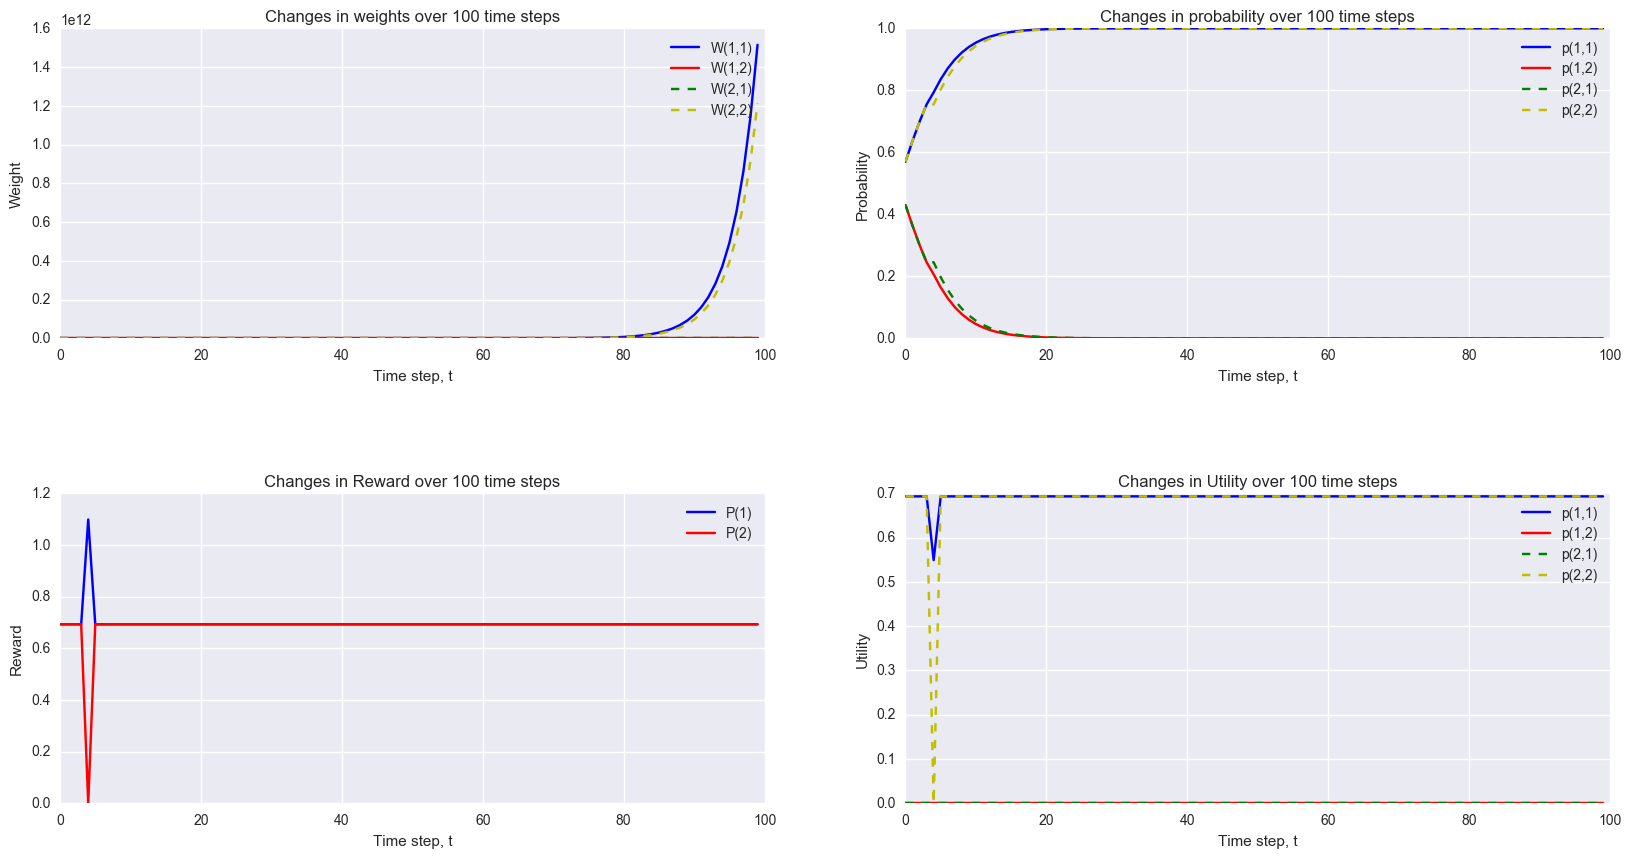

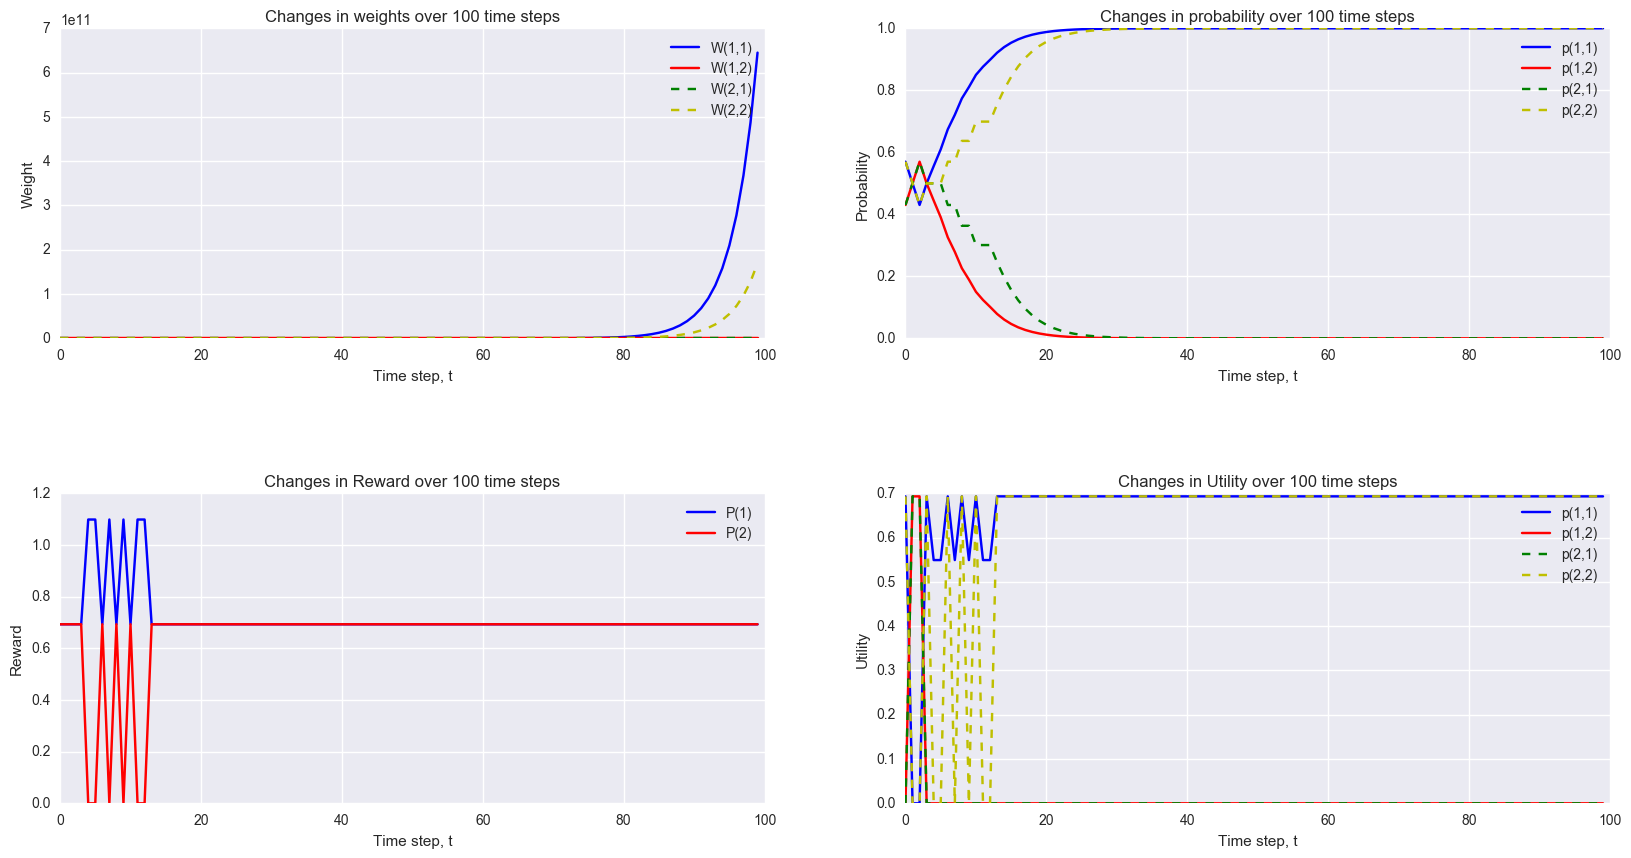

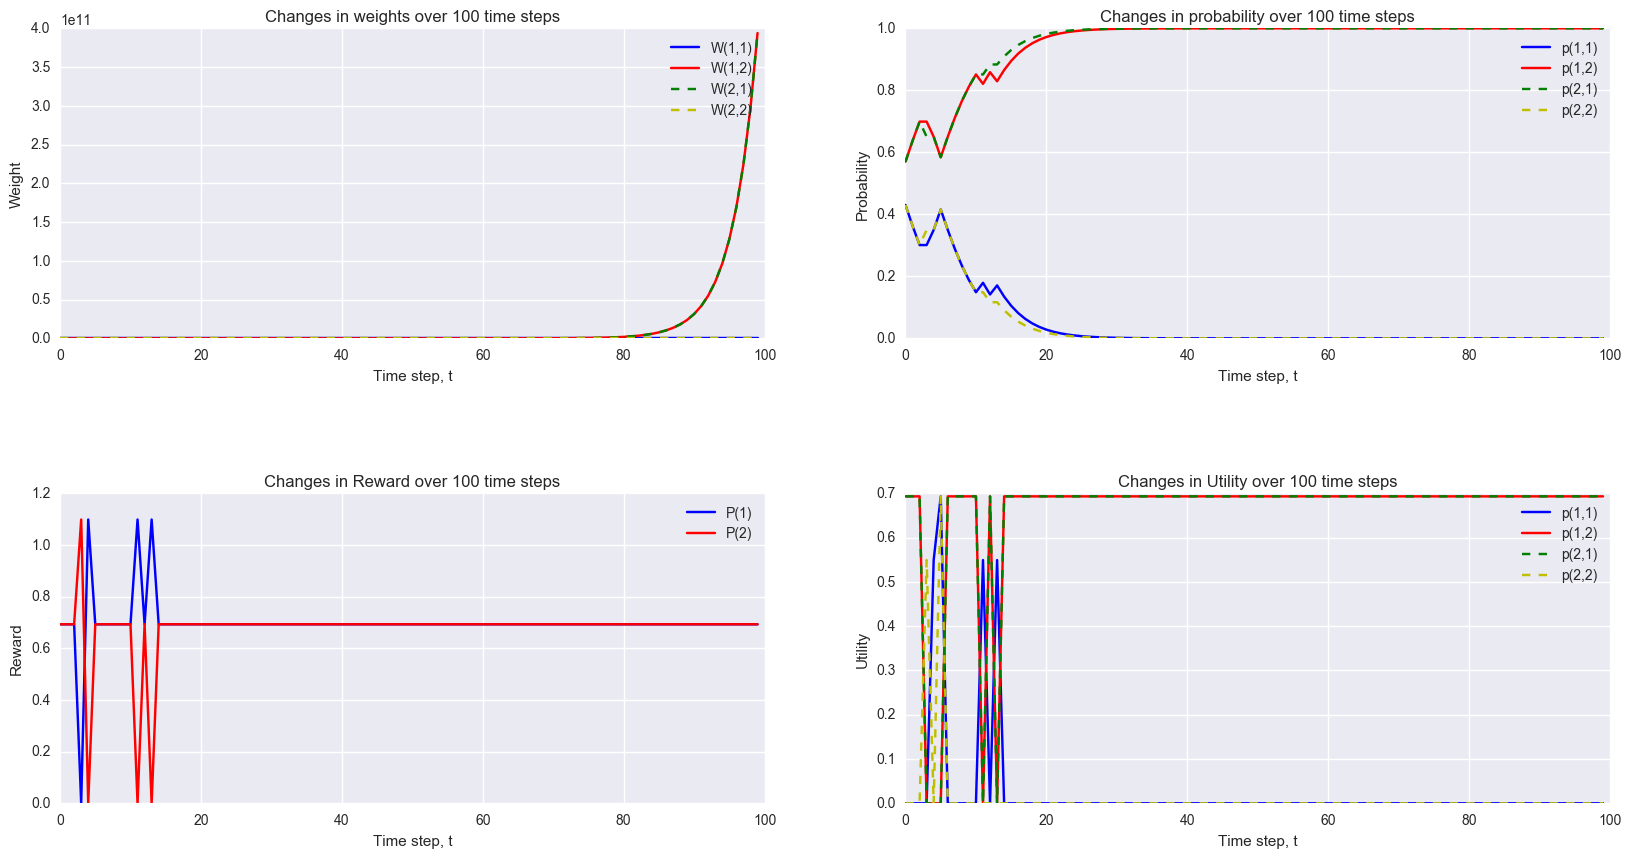

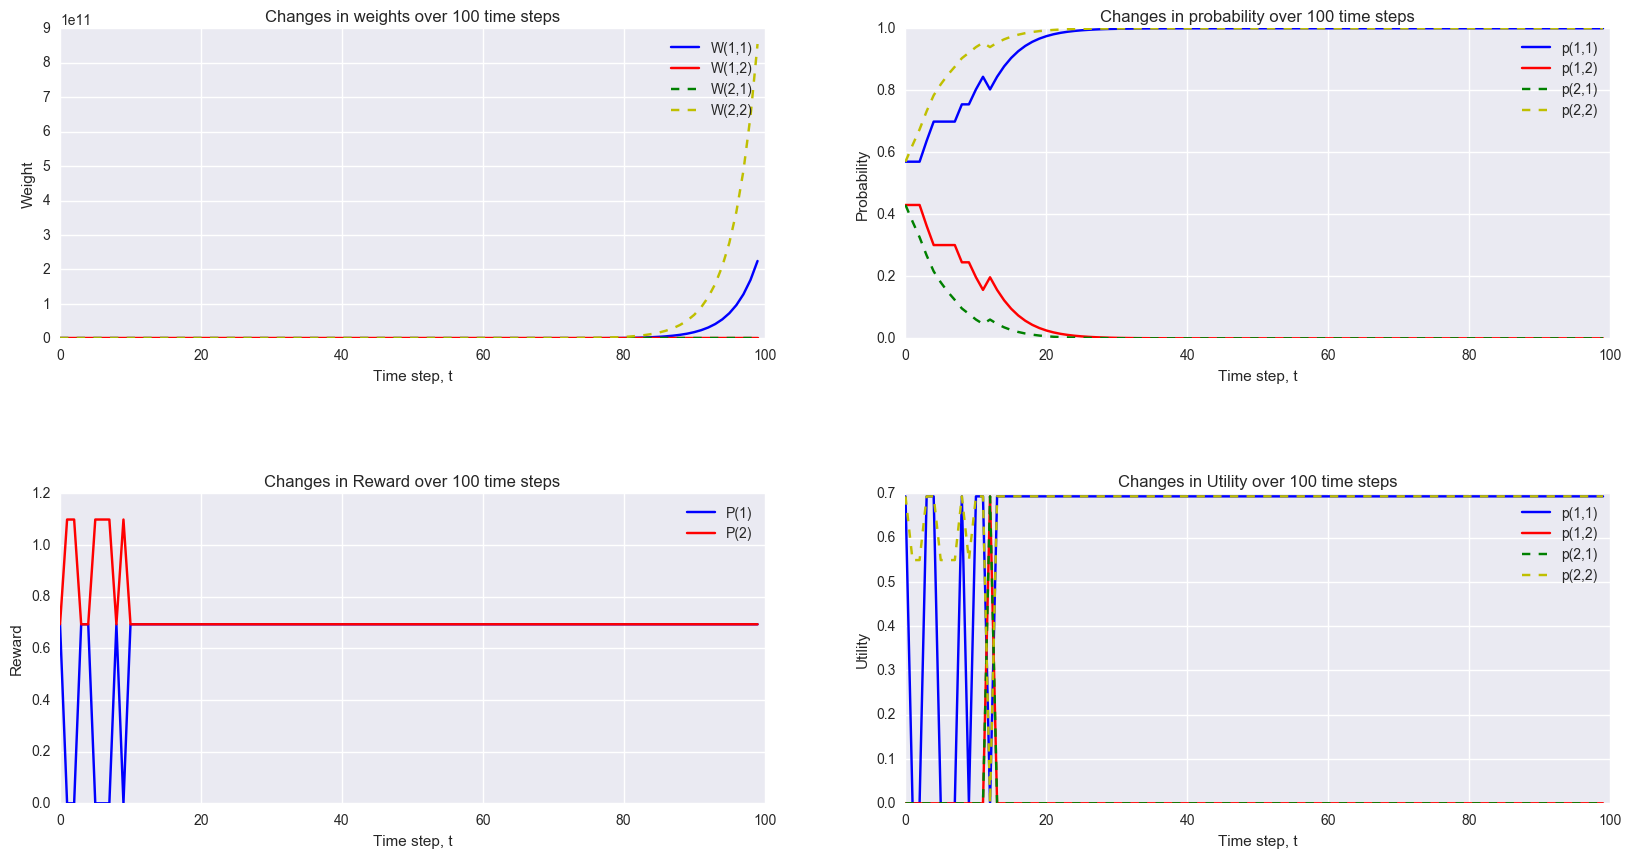

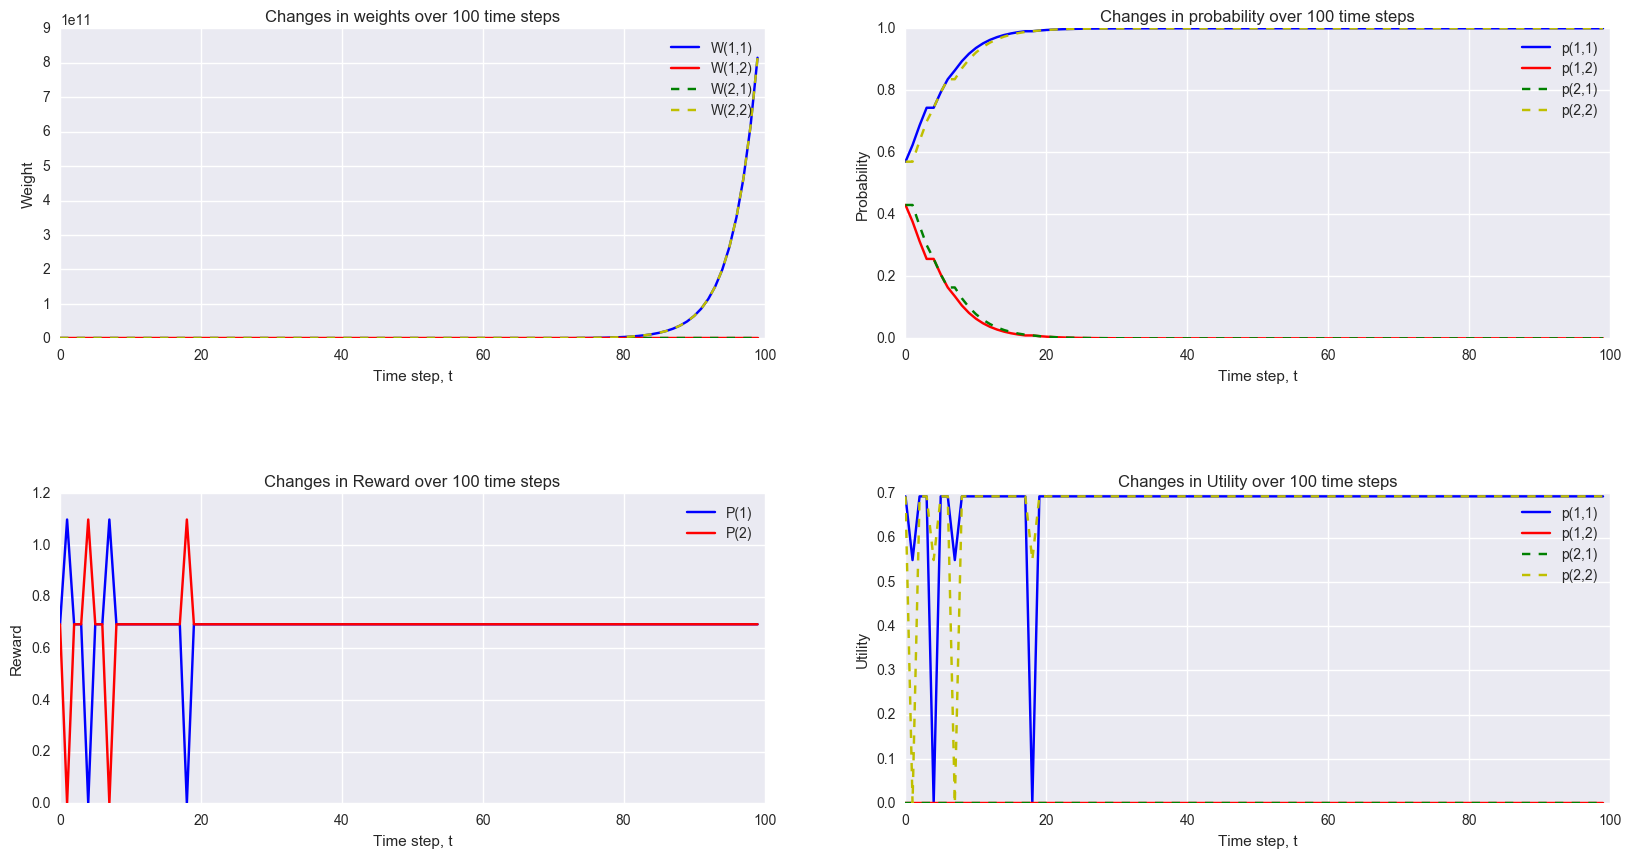

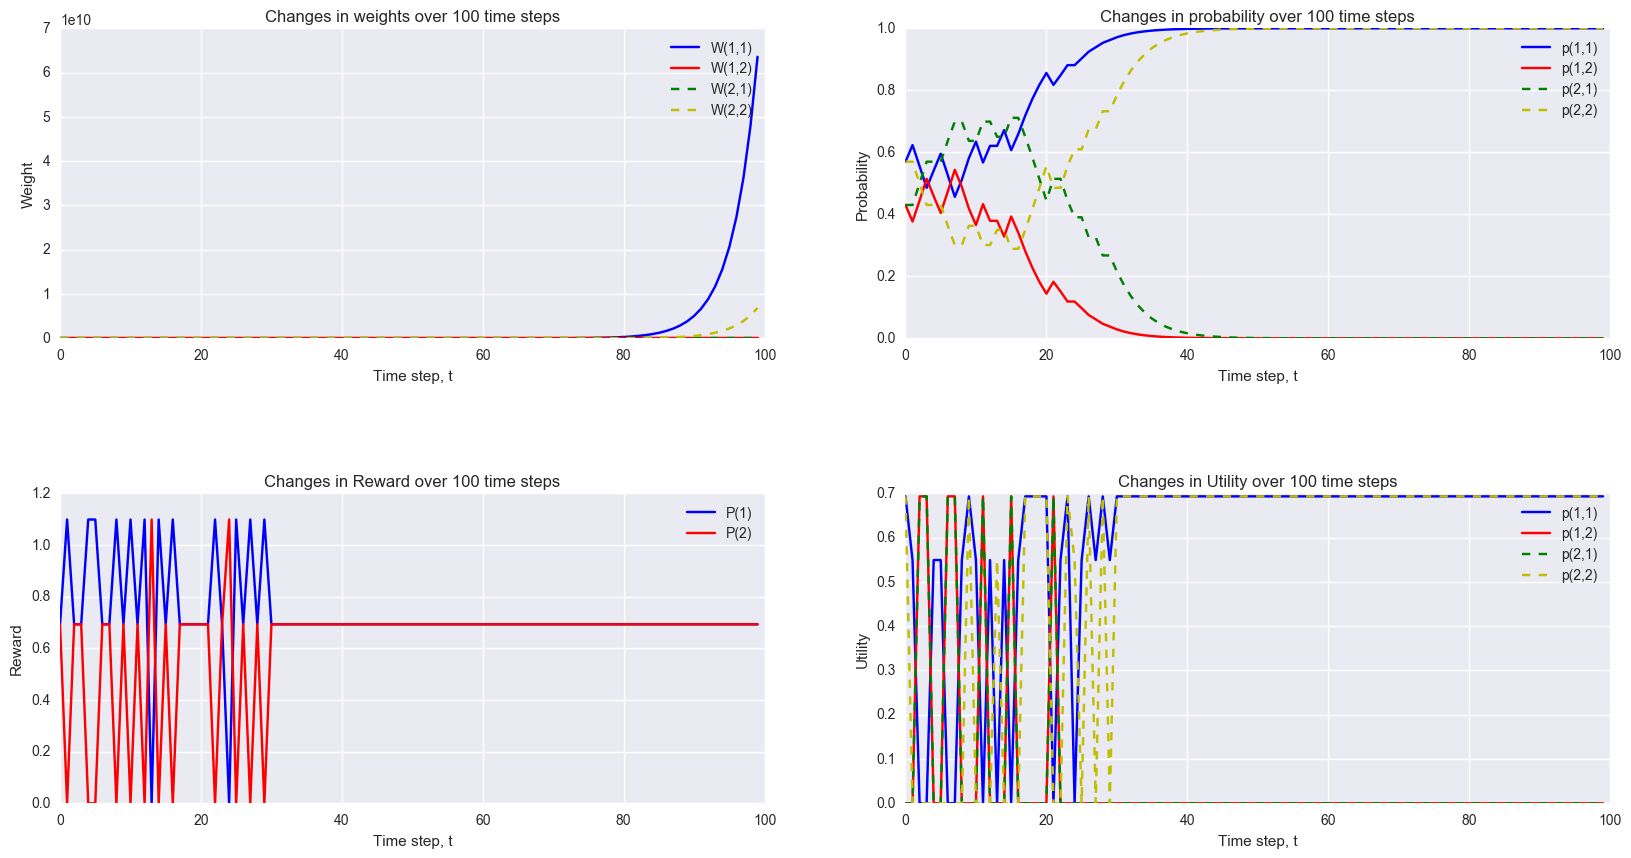

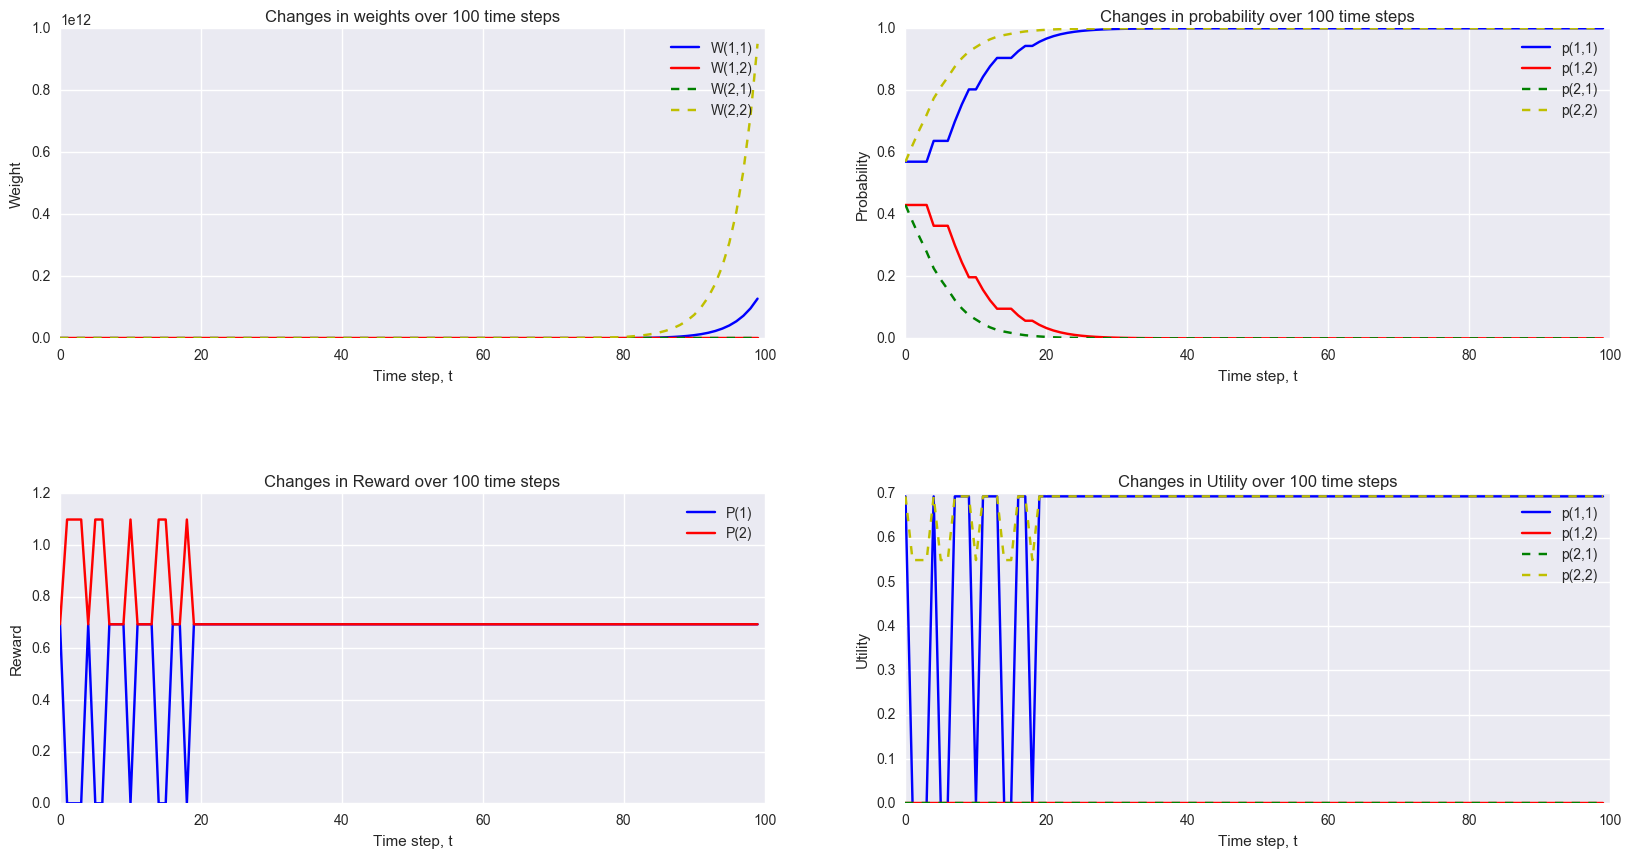

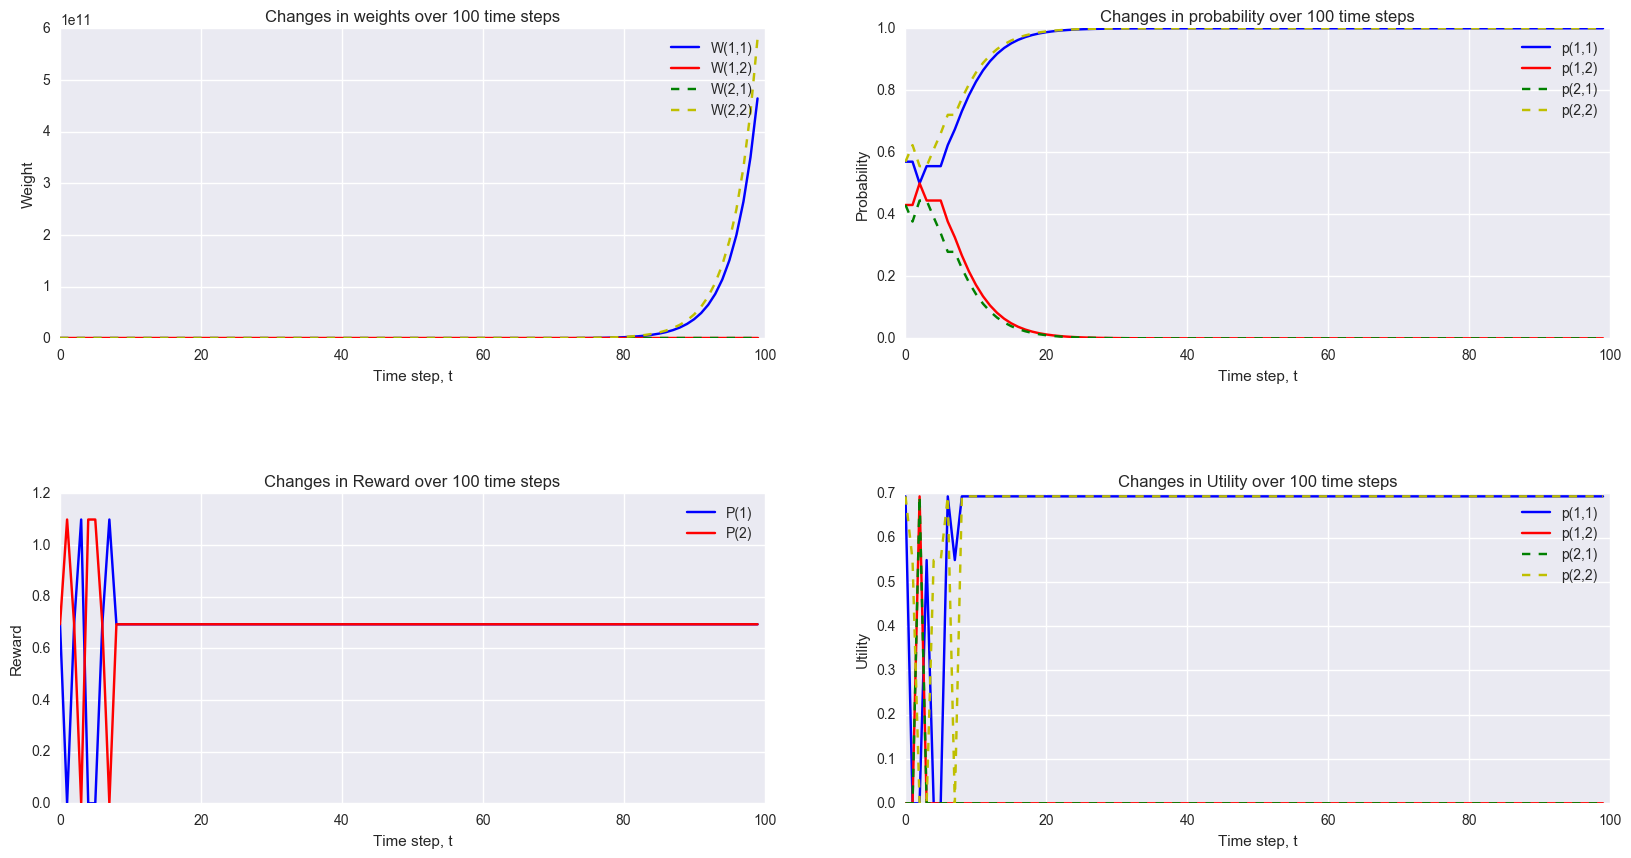

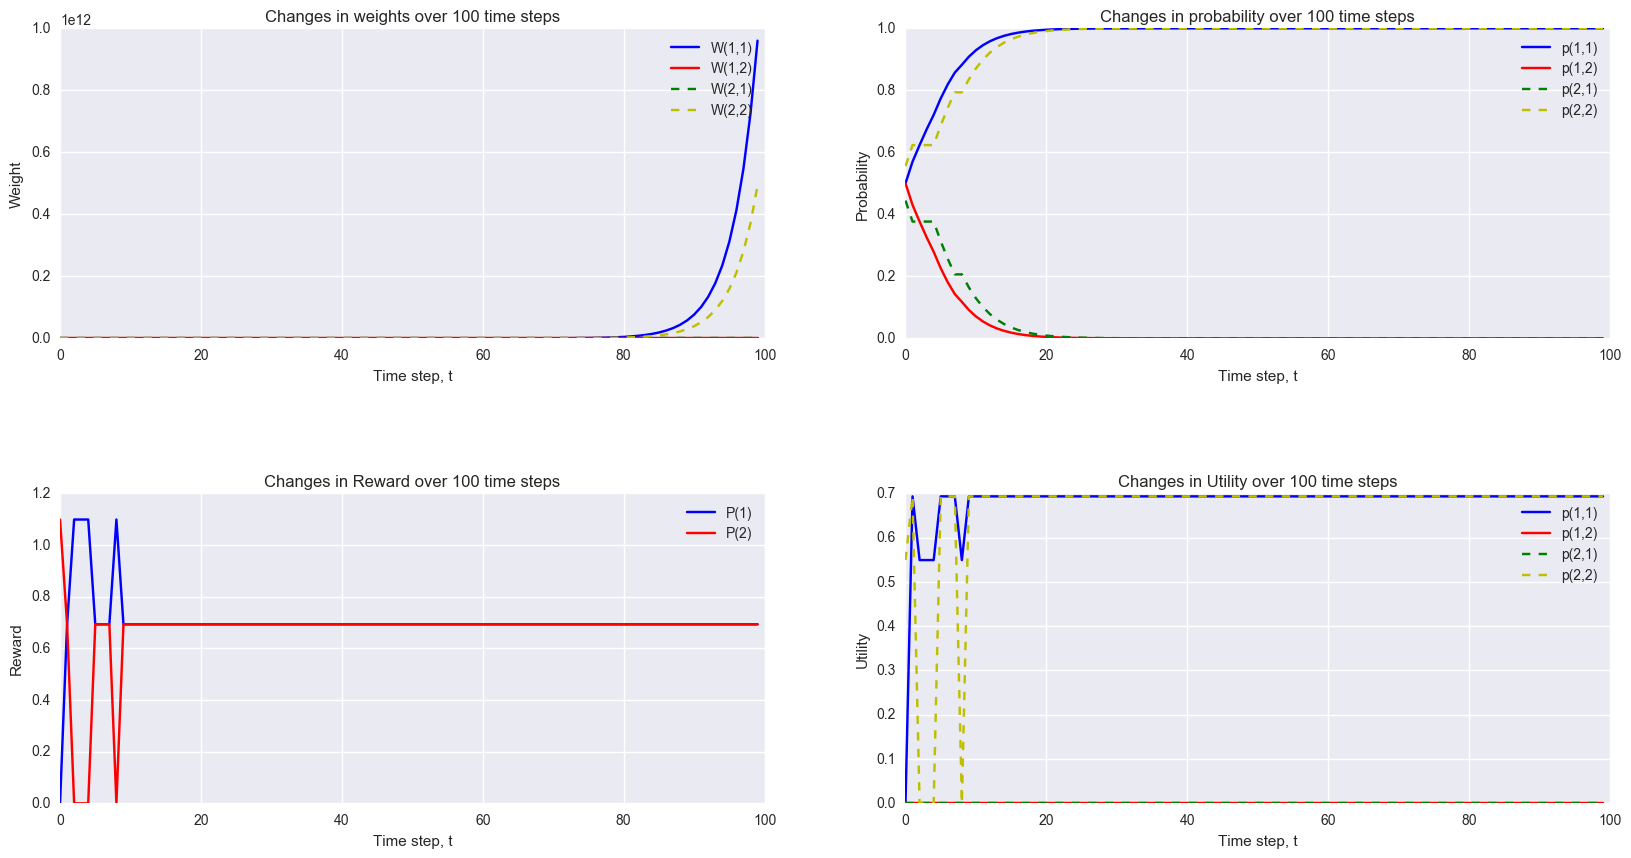

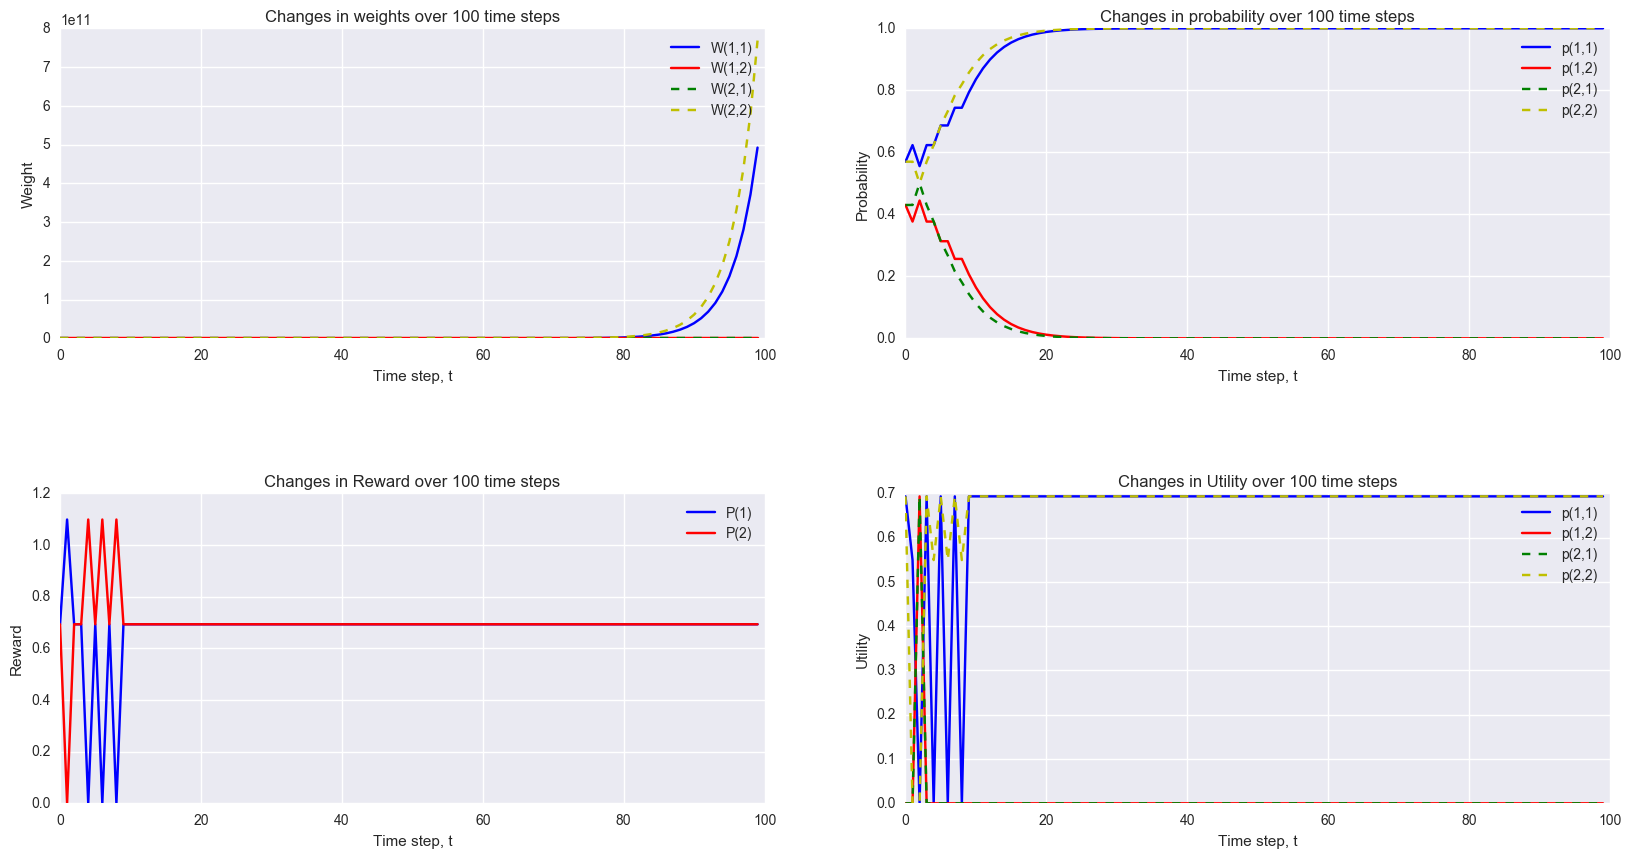

In [16]:
for i in np.arange(10):
    runandplot(W, alpha, epsilon, 100)